<a href="https://colab.research.google.com/github/abinashrasonowal/Lightweight-Deblur/blob/main/LightWeightDeblur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import cv2
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import matplotlib.pyplot as plt

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import zipfile

# Define the path to the zip file
zip_file_path = './sample_data/sharp.zip'

# Create a directory to extract the files
extract_dir = 'data'
os.makedirs(extract_dir, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print(f'Files extracted to {extract_dir}')


Files extracted to data


In [ ]:
# transform = transforms.Compose([
#     transforms.Resize((256, 256)) ,     # Resize to 256x256
#     transforms.ToTensor()               # Convert to Tensor (values in range [0, 1])
# ])

In [ ]:
# path_to_dir = '/content/drive/MyDrive'
path_to_dir = '.'

In [ ]:
img_names = {}
sharp = []

# Define image extensions you want to check for
image_extensions = {'.png', '.jpg', '.jpeg'}

for img in os.listdir(path_to_dir + '/data/sharp'):
    # Get the file extension
    _, ext = os.path.splitext(img)
    # Check if the extension is in the list of image extensions
    if ext.lower() in image_extensions:
        sharp.append(img)

img_names['sharp'] = sharp


In [ ]:
df=pd.DataFrame(img_names)

In [ ]:
len(df)

426

In [ ]:
i = 0
invalid_indices = []

for index, image_name in enumerate(df['sharp']):
    path_ = os.path.join(path_to_dir, 'data/sharp', image_name)
    try:
        img = cv2.imread(path_)
        if img is None:
            raise ValueError("Image not loaded, possibly due to unsupported format or missing file.")
    except Exception as e:
        print(f"Error loading image {path_}: {e}")
        invalid_indices.append(index)
        i += 1

# Remove invalid rows from DataFrame
df_cleaned = df.drop(index=invalid_indices).reset_index(drop=True)

print(f"Number of invalid images: {i}")

Error loading image ./data/sharp/b50.jpg: Image not loaded, possibly due to unsupported format or missing file.
Error loading image ./data/sharp/u5.jpg: Image not loaded, possibly due to unsupported format or missing file.
Error loading image ./data/sharp/s41.jpg: Image not loaded, possibly due to unsupported format or missing file.
Error loading image ./data/sharp/i39.jpg: Image not loaded, possibly due to unsupported format or missing file.
Error loading image ./data/sharp/s23.jpg: Image not loaded, possibly due to unsupported format or missing file.
Error loading image ./data/sharp/i37.jpg: Image not loaded, possibly due to unsupported format or missing file.
Error loading image ./data/sharp/u31.jpg: Image not loaded, possibly due to unsupported format or missing file.
Error loading image ./data/sharp/c70.jpg: Image not loaded, possibly due to unsupported format or missing file.
Error loading image ./data/sharp/u11.jpg: Image not loaded, possibly due to unsupported format or missing

In [ ]:
len(df_cleaned)

415

In [ ]:
train_df=df_cleaned[:350]
test_df=df_cleaned[350:]

In [ ]:
def ApplyBlur(img):
    img_np = np.array(img)
    blurred_img = cv2.GaussianBlur(img_np, (3, 3), 0)
    blurred_img = cv2.GaussianBlur(blurred_img, (3, 3), 0)
    return blurred_img

In [ ]:
# Define the augmentation pipeline
transform2 = A.Compose([
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0,value=0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.CenterCrop(height=256, width=256, p=1.0)
])

def augment_both(blurred_img,sharp_img):
  augmented = transform2(image=blurred_img, mask=sharp_img)
  return  augmented['image'] , augmented['mask']

In [ ]:
class MyData(Dataset):
    def __init__(self,df,sharpen_path):
        self.df=df
        self.sp=sharpen_path
    def __len__(self):
        return len(self.df)
    def __getitem__(self,index):
        sharpen_image_path=os.path.join(self.sp,self.df['sharp'][index])

        simg = cv2.imread(sharpen_image_path)
        simg = simg.astype(np.uint8)
        bimg = ApplyBlur(simg)
        bimg = (bimg / 255.0).astype(np.float32)
        simg = (simg / 255.0).astype(np.float32)

        bimg, simg = augment_both(bimg, simg)

        x = torch.tensor(bimg).permute(2, 0, 1)
        y = torch.tensor(simg).permute(2, 0, 1)
        return x,y


In [ ]:
train_data = MyData(train_df,path_to_dir+'/data/sharp')
test_data = MyData(test_df,path_to_dir+'/data/sharp')

In [ ]:
train_data[0][1].shape

torch.Size([3, 256, 256])

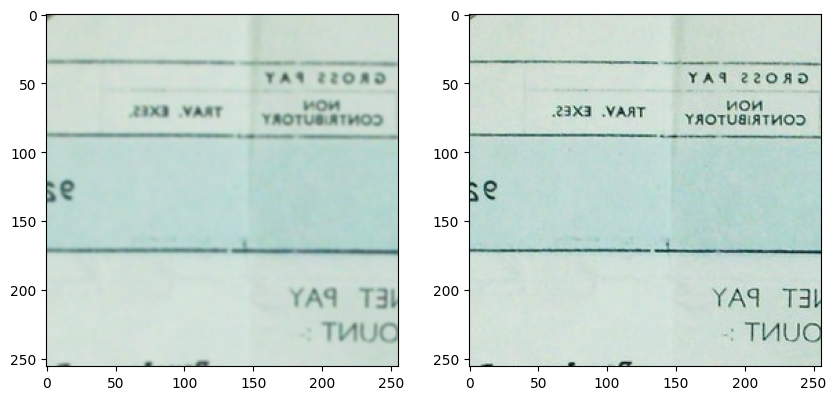

In [ ]:
fig, axis = plt.subplots(1, 2, figsize=(10, 10))
image1, image2 = train_data[9]
axis[0].imshow(image1.permute(1, 2, 0))
axis[1].imshow(image2.permute(1, 2, 0))

In [ ]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=True)

In [ ]:
# path_= os.path.join(path_to_dir+'/data/sharp',df['sharp'][0])
# img =cv2.imread(path_)
# print(img.shape)

(689, 654, 3)


In [ ]:
# i=0
# for image_name in df['sharp']:
#   try:
#     path_= os.path.join(path_to_dir+'/data/sharp',image_name)
#     img = cv2.imread(path_)
#     if img is None:
#         raise ValueError(f"Image not loaded, possibly due to unsupported format or missing file.")
#   except Exception as e:
#     print(f"Error loading image {path_}")
#     i=i+1
# print(i)

Error loading image ./data/sharp/b50.jpg
Error loading image ./data/sharp/u5.jpg
Error loading image ./data/sharp/s41.jpg
Error loading image ./data/sharp/i39.jpg
Error loading image ./data/sharp/s23.jpg
Error loading image ./data/sharp/i37.jpg
Error loading image ./data/sharp/u31.jpg
Error loading image ./data/sharp/c70.jpg
Error loading image ./data/sharp/u11.jpg
Error loading image ./data/sharp/i42.jpg
Error loading image ./data/sharp/i34.jpg
11


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)

        self.bottleneck = self.conv_block(256, 512)

        self.upconv3 = self.upconv_block(512, 256)
        self.follow_conv3 = self.conv_block(512, 256)

        self.upconv2 = self.upconv_block(256, 128)
        self.follow_conv2 = self.conv_block(256, 128)

        self.upconv1 = self.upconv_block(128, 64)
        self.follow_conv1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 3, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        )

    def forward(self, x):
        c1 = self.encoder1(x)
        p1 = nn.MaxPool2d(kernel_size=2, stride=2)(c1)

        c2 = self.encoder2(p1)
        p2 = nn.MaxPool2d(kernel_size=2, stride=2)(c2)

        c3 = self.encoder3(p2)
        p3 = nn.MaxPool2d(kernel_size=2, stride=2)(c3)

        bn = self.bottleneck(p3)

        u3 = self.upconv3(bn)
        u3 = torch.cat([u3, c3], dim=1)
        u3 = self.follow_conv3(u3)

        u2 = self.upconv2(u3)
        u2 = torch.cat([u2, c2], dim=1)
        u2 = self.follow_conv2(u2)

        u1 = self.upconv1(u2)
        u1 = torch.cat([u1, c1], dim=1)
        u1 = self.follow_conv1(u1)

        output = self.final_conv(u1)
        return output + x

# model = UNet().to(device)
# print(model)

In [ ]:
q = iter(train_loader)

In [ ]:
x,y=next(q)

In [ ]:
x.shape

torch.Size([10, 3, 256, 256])

In [ ]:
y.shape

torch.Size([10, 3, 256, 256])

In [ ]:
model=UNet()
l = nn.L1Loss(reduction = 'sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
total_step = len(train_loader)

In [ ]:
model = model.to(device)

In [ ]:
num_epochs=20
for epoch in range(num_epochs):
    loss = 0
    for i, (b_img, s_img) in enumerate(train_loader):
        optimizer.zero_grad()
        b_img, s_img = b_img.to(device, dtype=torch.float), s_img.to(device, dtype=torch.float)
        outputs = model(b_img)
        loss = l(outputs, s_img)


        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    # Save the model
torch.save(model.state_dict(), 'unet_model_withresnet256.pth')
print(f"Model saved")

Epoch [1/20], Loss: 72631.4922
Epoch [2/20], Loss: 78086.3828
Epoch [3/20], Loss: 44645.0469
Epoch [4/20], Loss: 82942.9844
Epoch [5/20], Loss: 75500.5625
Epoch [6/20], Loss: 76196.6094
Epoch [7/20], Loss: 47045.9844
Epoch [8/20], Loss: 36774.8906
Epoch [9/20], Loss: 39105.1914
Epoch [10/20], Loss: 40032.6250
Epoch [11/20], Loss: 33948.8125
Epoch [12/20], Loss: 40534.3203
Epoch [13/20], Loss: 39051.7773
Epoch [14/20], Loss: 35913.6719
Epoch [15/20], Loss: 32863.6719
Epoch [16/20], Loss: 36072.2148
Epoch [17/20], Loss: 37868.0234
Epoch [18/20], Loss: 34067.7656
Epoch [19/20], Loss: 18274.7480
Epoch [20/20], Loss: 28067.2422
Model saved


In [ ]:
def predict(t,i):
    image_tensor = t
    image_tensor = image_tensor.squeeze(0)
    image_tensor = image_tensor.detach().cpu()
    image_tensor=image_tensor[i:i+1].view(3,256,256)
    image_np = image_tensor.numpy()
    image_np = np.transpose(image_np, (1, 2, 0))
    return image_np


In [ ]:
w= iter(train_loader)

In [ ]:
x,y=next(w)

x=x.to(device)

p=model(x)

In [ ]:
image_tensor = p
image_tensor = image_tensor.squeeze(0)
image_tensor = image_tensor.detach().cpu()

In [ ]:
image_tensor.shape

torch.Size([10, 3, 256, 256])

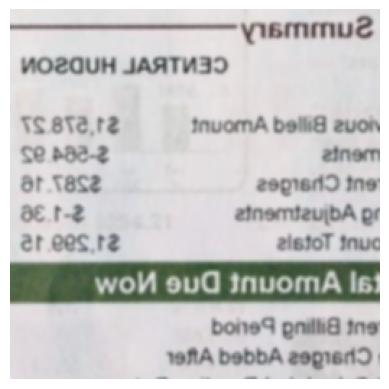

In [ ]:
plt.imshow(predict(x,1))
plt.axis('off')
plt.show()

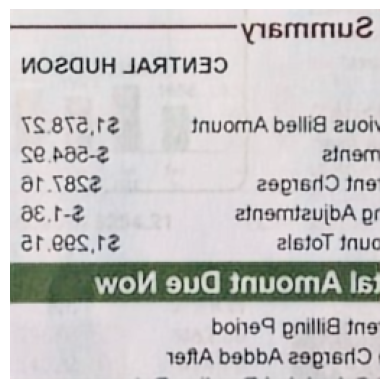

In [ ]:
plt.imshow(predict(p,1))
plt.axis('off')
plt.show()

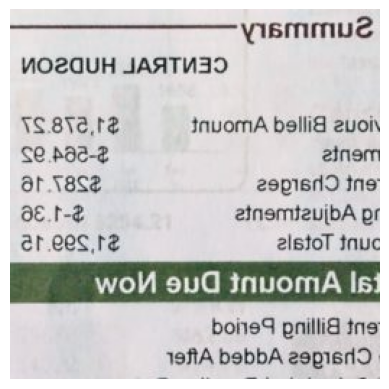

In [ ]:
plt.imshow(predict(y,1))
plt.axis('off')
plt.show()